# Battery Degradation Anomaly Detection 

This notebook detects **abnormal degradation** in Li‑ion batteries and reports **early‑warning lead time** before a practical EoL threshold.  

**Dataset:** `Battery_Data_Cleaned.csv` (same folder as this notebook).  
Expected columns: `type, ambient_temperature, battery_id, test_id, uid, filename, Capacity, Re, Rct`.

---

## How to run (no terminal)
**Jupyter (Anaconda):** open this `.ipynb` → **Kernel → Restart & Run All**.  
**Google Colab:** upload this notebook → run first cell (it will ask for CSV if not found) → **Runtime → Run all**.

**Outputs saved to the working folder:**
- `anomaly_summary.csv` — per‑battery metrics (baseline, EoL, first anomaly, lead).  
- `outputs/plot_battery_*.png` — example figures.  
- `report.html` — a one‑page HTML summary (you can print to PDF).

---


In [1]:
# Imports
import os, math, warnings, glob, io, base64
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
DATA_FILE = "Battery_Data_Cleaned.csv"


In [2]:
# Load data (local file or Colab upload fallback)
def load_data(path=DATA_FILE):
    if os.path.exists(path):
        return pd.read_csv(path)
    # Colab fallback
    try:
        from google.colab import files  # type: ignore
        print("Upload Battery_Data_Cleaned.csv")
        up = files.upload()
        key = next(iter(up.keys()))
        return pd.read_csv(key)
    except Exception as e:
        raise FileNotFoundError(f"CSV not found and Colab upload failed: {e}")

df = load_data()
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Batteries:", df['battery_id'].nunique() if 'battery_id' in df.columns else 'N/A')
df = df.sort_values(['battery_id','test_id']).reset_index(drop=True)
df.head()

Shape: (7368, 9)
Columns: ['type', 'ambient_temperature', 'battery_id', 'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct']
Batteries: 34


,type,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,1,24,5,0,5121,05121.csv,0.810030,0.072554,0.097699
1,-1,24,5,1,5122,05122.csv,1.049593,0.072554,0.097699
2,1,24,5,2,5123,05123.csv,1.049593,0.072554,0.097699
3,-1,24,5,3,5124,05124.csv,1.046029,0.072554,0.097699
4,1,24,5,4,5125,05125.csv,1.046029,0.072554,0.097699


In [3]:
# ---- Feature Engineering (robust baseline, rolling z-scores) ----
REQ = {'type','ambient_temperature','battery_id','test_id','uid','filename','Capacity','Re','Rct'}
miss = REQ - set(df.columns)
if miss:
    raise ValueError(f"Missing expected columns: {miss}")

def per_battery_features(g):
    g = g.sort_values('test_id').copy()
    n = len(g)

    # Robust baseline for "step-up" cells:
    # Use rolling median over first half (skip first 3 cycles), take 95th percentile of that curve
    first_half = g.iloc[:max(10, n//2)].copy()
    fh = first_half['Capacity'].copy()
    fh_rm = fh.rolling(15, min_periods=5).median()
    if fh_rm.dropna().shape[0] >= 5:
        baseline = np.percentile(fh_rm.dropna(), 95)
    else:
        baseline = g['Capacity'].head(5).median()

    g['baseline_cap'] = baseline
    g['eol_threshold'] = 0.8 * baseline

    # Deltas with explicit names expected downstream
    g['dcap'] = g['Capacity'].diff()
    g['dRe']  = g['Re'].diff()
    g['dRct'] = g['Rct'].diff()

    # Rolling robust z for deltas
    win = 21
    for col in ['dcap','dRe','dRct']:
        med = g[col].rolling(win, min_periods=10).median()
        mad = (g[col]-med).abs().rolling(win, min_periods=10).median() + 1e-12
        g[f'z_{col}'] = (g[col]-med)/(1.4826*mad)

    # Temperature and short-window slope
    g['temp'] = g['ambient_temperature']
    k = 5
    g['cap_slope_k'] = (g['Capacity'] - g['Capacity'].shift(k)) / (g['test_id'] - g['test_id'].shift(k)).replace(0, np.nan)
    g['cap_slope_k'] = g['cap_slope_k'].fillna(0.0)
    return g

df_feat = df.groupby('battery_id', group_keys=False).apply(per_battery_features)

# Quick sanity check
assert all(c in df_feat.columns for c in ['dcap','dRe','dRct','z_dcap','z_dRe','z_dRct']),     "Delta/z columns missing — check feature engineering step."
df_feat.head()

,type,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,baseline_cap,eol_threshold,dcap,dRe,dRct,z_dcap,z_dRe,z_dRct,temp,cap_slope_k
0,1,24,5,0,5121,05121.csv,0.810030,0.072554,0.097699,1.042457,0.833966,NaN,NaN,NaN,NaN,NaN,NaN,24,0.0
1,-1,24,5,1,5122,05122.csv,1.049593,0.072554,0.097699,1.042457,0.833966,0.239562,0.0,0.0,NaN,NaN,NaN,24,0.0
2,1,24,5,2,5123,05123.csv,1.049593,0.072554,0.097699,1.042457,0.833966,0.000000,0.0,0.0,NaN,NaN,NaN,24,0.0
3,-1,24,5,3,5124,05124.csv,1.046029,0.072554,0.097699,1.042457,0.833966,-0.003563,0.0,0.0,NaN,NaN,NaN,24,0.0
4,1,24,5,4,5125,05125.csv,1.046029,0.072554,0.097699,1.042457,0.833966,0.000000,0.0,0.0,NaN,NaN,NaN,24,0.0


In [4]:
# ---- Rule-based anomaly flags with warm-up ignore ----
def apply_rules(g):
    g = g.copy()
    strong = (g['z_dcap'] < -3) | (g['z_dRe'] > 3) | (g['z_dRct'] > 3)
    moderate = ((g['z_dcap'] < -2).astype(int) + (g['z_dRe'] > 2).astype(int) + (g['z_dRct'] > 2).astype(int)) >= 2
    warm_min = g['test_id'].min() + 10  # ignore first ~10 cycles
    g['anomaly_rule'] = ((strong | moderate) & (g['test_id'] >= warm_min)).astype(int)
    return g

df_rules = df_feat.groupby('battery_id', group_keys=False).apply(apply_rules)
df_rules[['battery_id','test_id','anomaly_rule']].head()

,battery_id,test_id,anomaly_rule
0,5,0,0
1,5,1,0
2,5,2,0
3,5,3,0
4,5,4,0


In [5]:
# ---- IsolationForest per battery (train on first 60%) ----
def fit_iforest(g):
    g = g.copy()
    feats = ['dcap','dRe','dRct','z_dcap','z_dRe','z_dRct','temp','cap_slope_k']
    X = g[feats].values.astype(float)
    # robust scale per battery
    med = np.median(X, axis=0)
    mad = np.median(np.abs(X - med), axis=0) + 1e-12
    Xs = (X - med)/(1.4826*mad)

    n = len(g)
    cut = max(10, int(0.6*n))
    model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
    model.fit(Xs[:cut])

    score = model.decision_function(Xs)
    pred  = model.predict(Xs)
    g['iforest_score'] = score
    g['anomaly_iforest'] = (pred == -1).astype(int)
    return g

df_if = df_rules.groupby('battery_id', group_keys=False).apply(fit_iforest)
df_if[['battery_id','test_id','anomaly_rule','anomaly_iforest']].head()

,battery_id,test_id,anomaly_rule,anomaly_iforest
0,5,0,0,0
1,5,1,0,0
2,5,2,0,0
3,5,3,0,0
4,5,4,0,0


In [6]:
# ---- Consensus, robust EoL, and lead-time ----
def compute_eol_and_lead(g):
    g = g.copy()

    # Phase-aware consensus: early (first 25%) use AND; later use OR. Apply 3-cycle hysteresis.
    tmin, tmax = g['test_id'].min(), g['test_id'].max()
    split = tmin + int(0.25*(tmax - tmin + 1))
    early = g['test_id'] <= split
    late  = g['test_id'] >  split

    cons = np.zeros(len(g), dtype=int)
    cons[early] = ((g.loc[early,'anomaly_rule'] == 1) & (g.loc[early,'anomaly_iforest'] == 1)).astype(int)
    cons[late]  = ((g.loc[late,'anomaly_rule'] == 1) | (g.loc[late,'anomaly_iforest'] == 1)).astype(int)
    g['anomaly_raw'] = cons

    # Hysteresis: need >=2 hits in a 3-cycle window
    g['anomaly'] = (g['anomaly_raw'].rolling(3, min_periods=1).sum() >= 2).astype(int)

    # Robust EoL: rolling median(5) below threshold for 5 consecutive cycles
    cap_med5 = g['Capacity'].rolling(5, min_periods=5).median()
    below = cap_med5 < g['eol_threshold']
    consec = below.rolling(5, min_periods=5).sum() >= 5
    idx = np.where(consec.values)[0]
    eol_test_id = int(g.iloc[idx[0]]['test_id']) if len(idx) else None

    # First anomaly after warm-up
    warm_min = g['test_id'].min() + 10
    idxa = np.where((g['anomaly'].values == 1) & (g['test_id'].values >= warm_min))[0]
    first_anom_id = int(g.iloc[idxa[0]]['test_id']) if len(idxa) else None

    lead = (eol_test_id - first_anom_id) if (eol_test_id is not None and first_anom_id is not None and eol_test_id > first_anom_id) else None
    g['eol_test_id'] = eol_test_id
    g['first_anom_test_id'] = first_anom_id
    g['lead_cycles'] = lead
    return g

df_out = df_if.groupby('battery_id', group_keys=False).apply(compute_eol_and_lead)

def summarize(g):
    g = g.copy()
    return pd.Series({
        'battery_id': int(g['battery_id'].iloc[0]),
        'baseline_capacity': float(g['baseline_cap'].iloc[0]),
        'eol_threshold': float(g['eol_threshold'].iloc[0]),
        'eol_test_id': g['eol_test_id'].iloc[-1] if pd.notnull(g['eol_test_id'].iloc[-1]) else None,
        'first_anomaly_test_id': g['first_anom_test_id'].iloc[-1] if pd.notnull(g['first_anom_test_id'].iloc[-1]) else None,
        'lead_cycles': g['lead_cycles'].iloc[-1] if pd.notnull(g['lead_cycles'].iloc[-1]) else None,
        'anomaly_count': int(g['anomaly'].sum()),
        'total_cycles': int(g['test_id'].max() - g['test_id'].min() + 1)
    })

summary = df_out.groupby('battery_id').apply(summarize).reset_index(drop=True)
summary = summary.sort_values(['lead_cycles'], ascending=[False])
summary.head(10)

,battery_id,baseline_capacity,eol_threshold,eol_test_id,first_anomaly_test_id,lead_cycles,anomaly_count,total_cycles
1,6.0,1.102991,0.882393,380.0,144.0,236.0,186.0,556.0
19,42.0,1.002988,0.802390,108.0,72.0,36.0,58.0,275.0
21,44.0,0.978228,0.782583,108.0,72.0,36.0,72.0,275.0
22,45.0,0.656459,0.525167,86.0,50.0,36.0,51.0,184.0
20,43.0,0.986053,0.788843,108.0,78.0,30.0,68.0,275.0
28,51.0,0.801506,0.641204,26.0,22.0,4.0,14.0,62.0
26,49.0,0.864093,0.691274,24.0,22.0,2.0,6.0,62.0
27,50.0,0.936782,0.749426,39.0,38.0,1.0,6.0,61.0
0,5.0,1.042457,0.833966,NaN,142.0,NaN,171.0,556.0
2,7.0,1.058020,0.846416,NaN,144.0,NaN,223.0,556.0


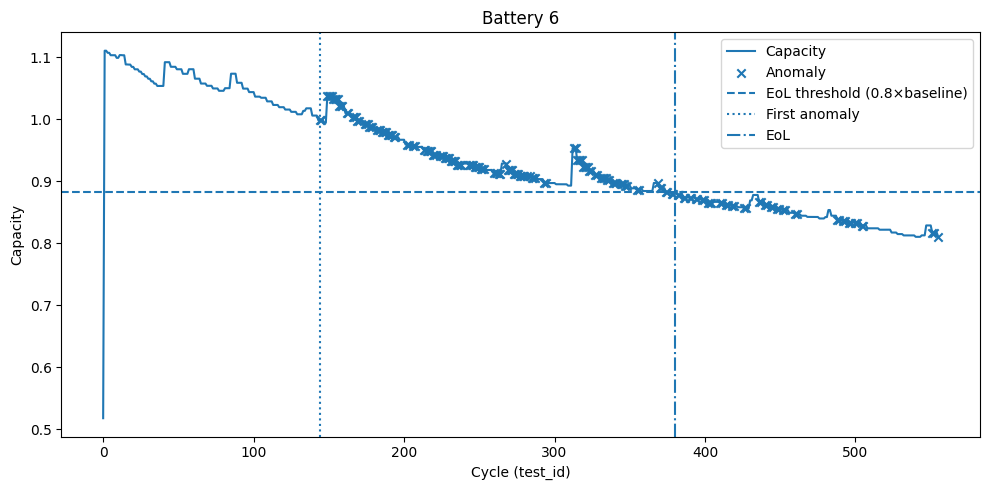

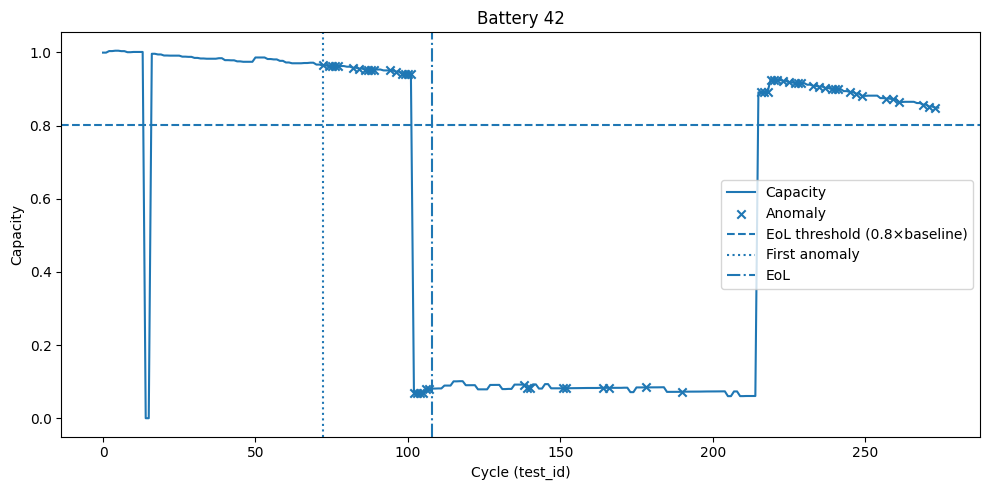

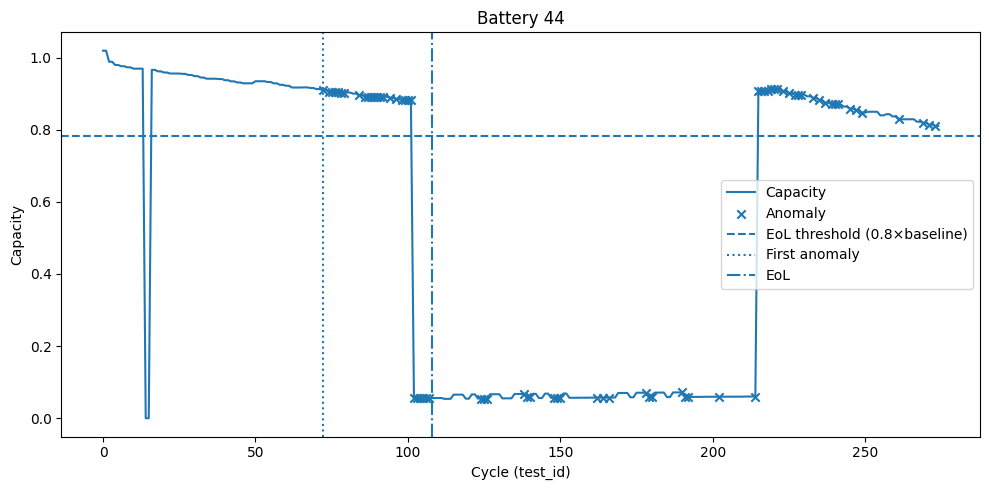

,battery_id,baseline_capacity,eol_threshold,eol_test_id,first_anomaly_test_id,lead_cycles,anomaly_count,total_cycles
1,6.0,1.102991,0.882393,380.0,144.0,236.0,186.0,556.0
19,42.0,1.002988,0.802390,108.0,72.0,36.0,58.0,275.0
21,44.0,0.978228,0.782583,108.0,72.0,36.0,72.0,275.0
22,45.0,0.656459,0.525167,86.0,50.0,36.0,51.0,184.0
20,43.0,0.986053,0.788843,108.0,78.0,30.0,68.0,275.0
28,51.0,0.801506,0.641204,26.0,22.0,4.0,14.0,62.0
26,49.0,0.864093,0.691274,24.0,22.0,2.0,6.0,62.0
27,50.0,0.936782,0.749426,39.0,38.0,1.0,6.0,61.0
0,5.0,1.042457,0.833966,NaN,142.0,NaN,171.0,556.0
2,7.0,1.058020,0.846416,NaN,144.0,NaN,223.0,556.0


In [7]:
# ---- Save up to 3 plots (best lead times) ----
import os
os.makedirs("outputs", exist_ok=True)

# pick best 3 by lead time (drop NA)
cands = summary.dropna(subset=['lead_cycles']).sort_values('lead_cycles', ascending=False)
if cands.empty:
    picks = summary['battery_id'].head(3).tolist()
else:
    picks = cands['battery_id'].head(3).tolist()

def plot_battery(g, savepath):
    g = g.copy()
    fig = plt.figure(figsize=(10,5))
    plt.plot(g['test_id'], g['Capacity'], label='Capacity')
    an = g[g['anomaly'] == 1]
    if len(an):
        plt.scatter(an['test_id'], an['Capacity'], marker='x', label='Anomaly')
    plt.axhline(g['eol_threshold'].iloc[0], linestyle='--', label='EoL threshold (0.8×baseline)')
    fa = g['first_anom_test_id'].iloc[-1]
    eol = g['eol_test_id'].iloc[-1]
    if pd.notnull(fa):
        plt.axvline(int(fa), linestyle=':', label='First anomaly')
    if pd.notnull(eol):
        plt.axvline(int(eol), linestyle='-.', label='EoL')
    plt.xlabel('Cycle (test_id)')
    plt.ylabel('Capacity')
    bid = int(g['battery_id'].iloc[0])
    plt.title(f"Battery {bid}")
    plt.legend()
    plt.tight_layout()
    fig.savefig(savepath)
    plt.show()

for b in picks:
    gb = df_out[df_out['battery_id'] == b]
    plot_battery(gb, f"outputs/plot_battery_{b}.png")

summary.head(10)

In [8]:
# ---- Save outputs and print Top-5 early warnings ----
summary.to_csv("anomaly_summary.csv", index=False)

top5 = summary.dropna(subset=['lead_cycles']).head(5)
if not top5.empty:
    print("\nTop-5 early warnings:")
    print(top5[['battery_id','first_anomaly_test_id','eol_test_id','lead_cycles']].to_string(index=False))
else:
    print("No positive lead times detected.")

print(f"Saved anomaly_summary.csv and {len(glob.glob('outputs/*.png'))} plot(s) in ./outputs")


Top-5 early warnings:
 battery_id  first_anomaly_test_id  eol_test_id  lead_cycles
        6.0                  144.0        380.0        236.0
       42.0                   72.0        108.0         36.0
       44.0                   72.0        108.0         36.0
       45.0                   50.0         86.0         36.0
       43.0                   78.0        108.0         30.0
Saved anomaly_summary.csv and 3 plot(s) in ./outputs


In [9]:
# ---- Build a one-page HTML report (no extra deps) ----
def img_to_base64(path):
    with open(path, 'rb') as f:
        return base64.b64encode(f.read()).decode('ascii')

rows = summary.copy()
rows['lead_cycles'] = rows['lead_cycles'].fillna('—')
table_html = rows.head(10).to_html(index=False)

# Embed up to 3 images
imgs = sorted(glob.glob('outputs/plot_battery_*.png'))[:3]
img_tags = ""
for p in imgs:
    b64 = img_to_base64(p)
    img_tags += f'<div style="margin:10px 0;"><img src="data:image/png;base64,{b64}" alt="{os.path.basename(p)}" style="max-width:100%;height:auto;"></div>'

html = f"""
<!doctype html>
<html>
<head>
<meta charset="utf-8">
<title>Battery Anomaly Detection — Report</title>
</head>
<body>
<h2>Battery Degradation Anomaly Detection — Report</h2>
<p><b>EoL rule:</b> rolling median(5) below 0.8×baseline for 5 consecutive cycles.</p>
<p><b>Anomaly consensus:</b> early 25% (Rule AND IF), later (Rule OR IF), with 3‑cycle hysteresis.</p>
<h3>Top summary (first 10 rows)</h3>
{table_html}
<h3>Example plots</h3>
{img_tags if img_tags else '<p>No plots saved.</p>'}
</body>
</html>
"""

with open("report.html", "w", encoding="utf-8") as f:
    f.write(html)

print("Wrote report.html")

Wrote report.html
